# Week 4 Assignment

To join a kaggle competition: Predict which Tweets are about real disasters and which ones are not. For this assignment I will look at GRU and also biGRU.


Disclaimer: There are segments that uses colab pro completion.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# EDA

There is some stuff we have to look at like how the tweets are structured, the balance of the dataset.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 4/nlp/train.csv')

In [3]:
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df[df['target'] == 0].head(5)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [5]:
negative_samples = df[df['target'] == 0]['target'].value_counts()
positive_samples = df[df['target'] == 1]['target'].value_counts()

print(f'Negative Samples: {negative_samples}')
print(f'Positive Samples: {positive_samples}')

Negative Samples: target
0    4342
Name: count, dtype: int64
Positive Samples: target
1    3271
Name: count, dtype: int64


Let's look at a couple of examples with keyword and locations and see whether its even relevant to our classification task.

In [6]:
keyword = df[df['keyword'].notna()]
keyword.head(5)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [7]:
keyword.tail(5)

,id,keyword,location,text,target
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0


Let's combine the columns and do some simple preprocessing of the text. Why do I combine the column? It is because we don't want to lose important keywords, or possibly locations? that may be associated with the disaster. I will write a function for this so that we can apply the same preprocessing steps to the test set ultimately.

In [8]:
STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()

def text_processor(row):
    text = ""
    if pd.notna(row['keyword']):
        text += row['keyword'] + ' '
    if pd.notna(row['location']):
        text += row['location'] + ' '
    if pd.notna(row['text']):
        text += row['text']

    text = text.lower()

    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
              if token not in string.punctuation and token not in STOP_WORDS]
    tokens = [LEMMATIZER.lemmatize(token) for token in tokens]
    processed_text = ' '.join(tokens)

    return processed_text

In [9]:
text = text_processor(df.iloc[7579])
print(text)

wrecked vancouver canada three day work 've pretty much wrecked hahaha shoutout family one


In [10]:
df['combined_text'] = df.apply(text_processor, axis=1)

In [11]:
df.head(5)

,id,keyword,location,text,target,combined_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked 'shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfire evacuation orde..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


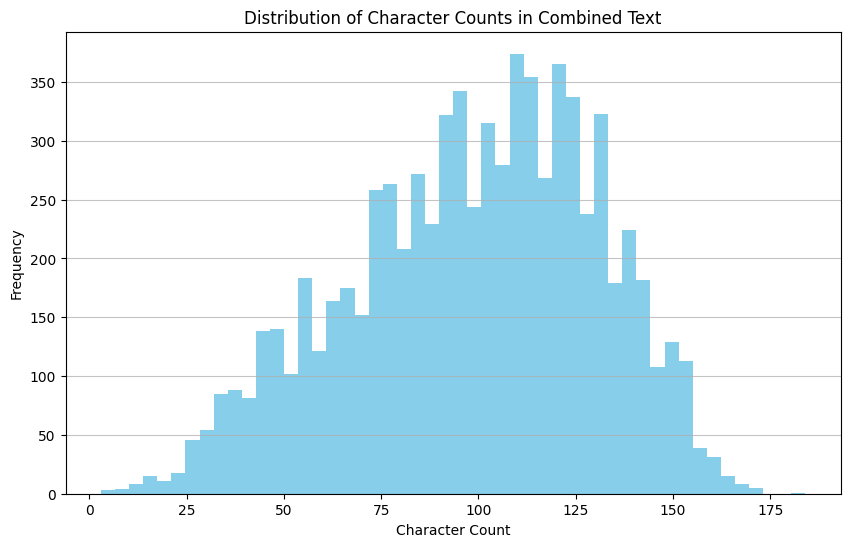

In [12]:
char_counts = df['combined_text'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(char_counts, bins=50, color='skyblue')
plt.title('Distribution of Character Counts in Combined Text')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


If you look at the distribution graph above, you will find that it is actually quite short, I mean it's twitter afterall. The max character count is no more than 175, so its around 5 characters per word so around 25 word-ish?

In [13]:
train_set, val_set = train_test_split(df, test_size=0.2, random_state=1108, stratify=df['target'])

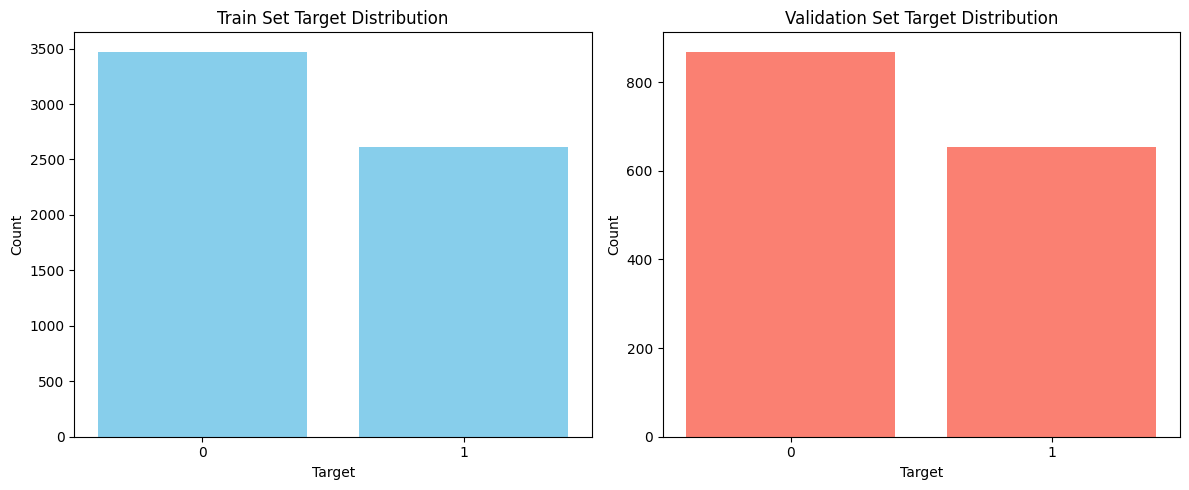

In [14]:
train_counts = train_set['target'].value_counts().sort_index()
val_counts = val_set['target'].value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(train_counts.index, train_counts.values, color='skyblue')
ax[0].set_title("Train Set Target Distribution")
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Count")
ax[0].set_xticks([0, 1])

ax[1].bar(val_counts.index, val_counts.values, color='salmon')
ax[1].set_title("Validation Set Target Distribution")
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Count")
ax[1].set_xticks([0, 1])

plt.tight_layout()
plt.show()

The above is quite well balanced if you ask me, so we will be unlikely to use/or require any balancing methods.

In [15]:
print(val_counts)

target
0    869
1    654
Name: count, dtype: int64


# Training with GRU

Let's find out the total vocab size using keras tokenizer

In [16]:
texts = df['combined_text'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
print(f'vocab size is {vocab_size}')

vocab size is 22862


In [17]:
embedding_dim = 50
max_sequence_length = 50

X_train = tokenizer.texts_to_sequences(train_set['combined_text'])
X_val = tokenizer.texts_to_sequences(val_set['combined_text'])

X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_sequence_length, padding='post', truncating='post')

y_train = np.array(train_set['target'])
y_val = np.array(val_set['target'])

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")


X_train shape: (6090, 50), X_val shape: (1523, 50)
y_train shape: (6090,), y_val shape: (1523,)


In [18]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(64),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5531 - loss: 0.6866 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5761 - loss: 0.6822 - val_accuracy: 0.5706 - val_loss: 0.6842
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5734 - loss: 0.6843 - val_accuracy: 0.5706 - val_loss: 0.6844
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5712 - loss: 0.6845 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5729 - loss: 0.6837 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5687 - loss: 0.6845 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5638 - loss: 0.6855 - val_accuracy: 0.5706 - val_loss: 0.6838
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5677 - loss: 0.6845 - val_accuracy: 0.

Numerous approach was employed with toggling of the hyperparameters, learning rate, GRU neurons, etc, but the val_accuracy is actually stuck at 0.5706, this suggests that predicting all as one class was done by the model, which is not what we want at all! The model is not learning at all. Let's try to use the glove pretrained embeddings and see whether it can help with it.


In [20]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [21]:
glove_path = "glove.6B.50d.txt"

embeddings_index = {}

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


In [22]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
missing_words_count = 0

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)

        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            missing_words_count += 1

print(f"Percentage of missing words: {missing_words_count / len(tokenizer.word_index) * 100:.2f}%")

Percentage of missing words: 44.33%


In [23]:
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length,
              weights=[embedding_matrix], trainable=False),
    GRU(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,143,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,143,100 (4.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,143,100 (4.36 MB)

In [24]:
history = model2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5619 - loss: 0.6878 - val_accuracy: 0.5706 - val_loss: 0.6836
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5764 - loss: 0.6811 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5709 - loss: 0.6836 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5674 - loss: 0.6854 - val_accuracy: 0.5706 - val_loss: 0.6835
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5670 - loss: 0.6855 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5813 - loss: 0.6810 - val_accuracy: 0.5706 - val_loss: 0.6842
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5758 - loss: 0.6826 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5754 - loss: 0.6829 - val_accuracy: 0.

Despite using glove embeddings, it appears that the val_accuracy is still stuck and the model is still not learning, we shall try biGRU to see whether it helps since it is bidirectional.

In [25]:
model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length,
              weights=[embedding_matrix], trainable=False),
    Bidirectional(GRU(32, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model3.summary()

history = model3.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,143,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,143,100 (4.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,143,100 (4.36 MB)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5027 - loss: 0.9651 - val_accuracy: 0.5351 - val_loss: 0.7003
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5669 - loss: 0.8384 - val_accuracy: 0.6067 - val_loss: 0.6696
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5922 - loss: 0.7607 - val_accuracy: 0.6454 - val_loss: 0.6370
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6072 - loss: 0.7368 - val_accuracy: 0.6717 - val_loss: 0.6137
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6073 - loss: 0.7207 - val_accuracy: 0.6940 - val_loss: 0.5983
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6400 - loss: 0.6832 - val_accuracy: 0.7144 - val_loss: 0.5833
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6542 - loss: 0.6754 - val_accuracy: 0.7196 - val_loss: 0.5711
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6667 - loss: 0.6386 - val_accu

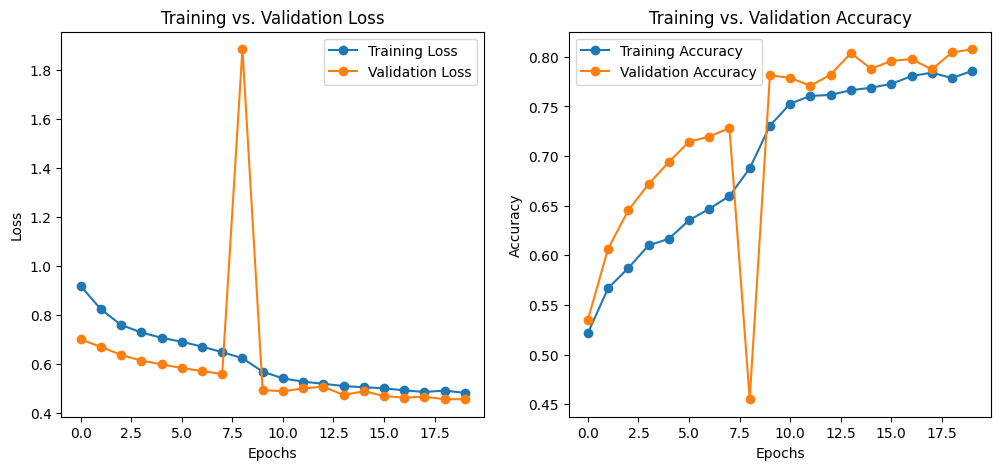

In [26]:
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.show()


I have now gotten a pretty decent model and I will attempt it on the test.csv. As you can see, we have added various techniques including batch normalizations after layers among other trial and errors.

In [30]:
df_eg = pd.read_csv('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 4/nlp/sample_submission.csv')
df_eg

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [27]:
df_submit = pd.read_csv('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 4/nlp/test.csv')

In [31]:
df_submit['combined_text'] = df_submit.apply(text_processor, axis=1)

In [32]:
X_submit = tokenizer.texts_to_sequences(df_submit['combined_text'])
X_submit = pad_sequences(X_submit, maxlen=max_sequence_length, padding='post', truncating='post')
predictions = model3.predict(X_submit)
df_submit['target'] = (predictions > 0.5).astype(int)

df_submit.head(5)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,id,keyword,location,text,combined_text,target
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,1


In [34]:
df_final = df_submit.iloc[:, [0, -1]]

In [37]:
df_final.to_csv('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 4/nlp/submission.csv', index=False)

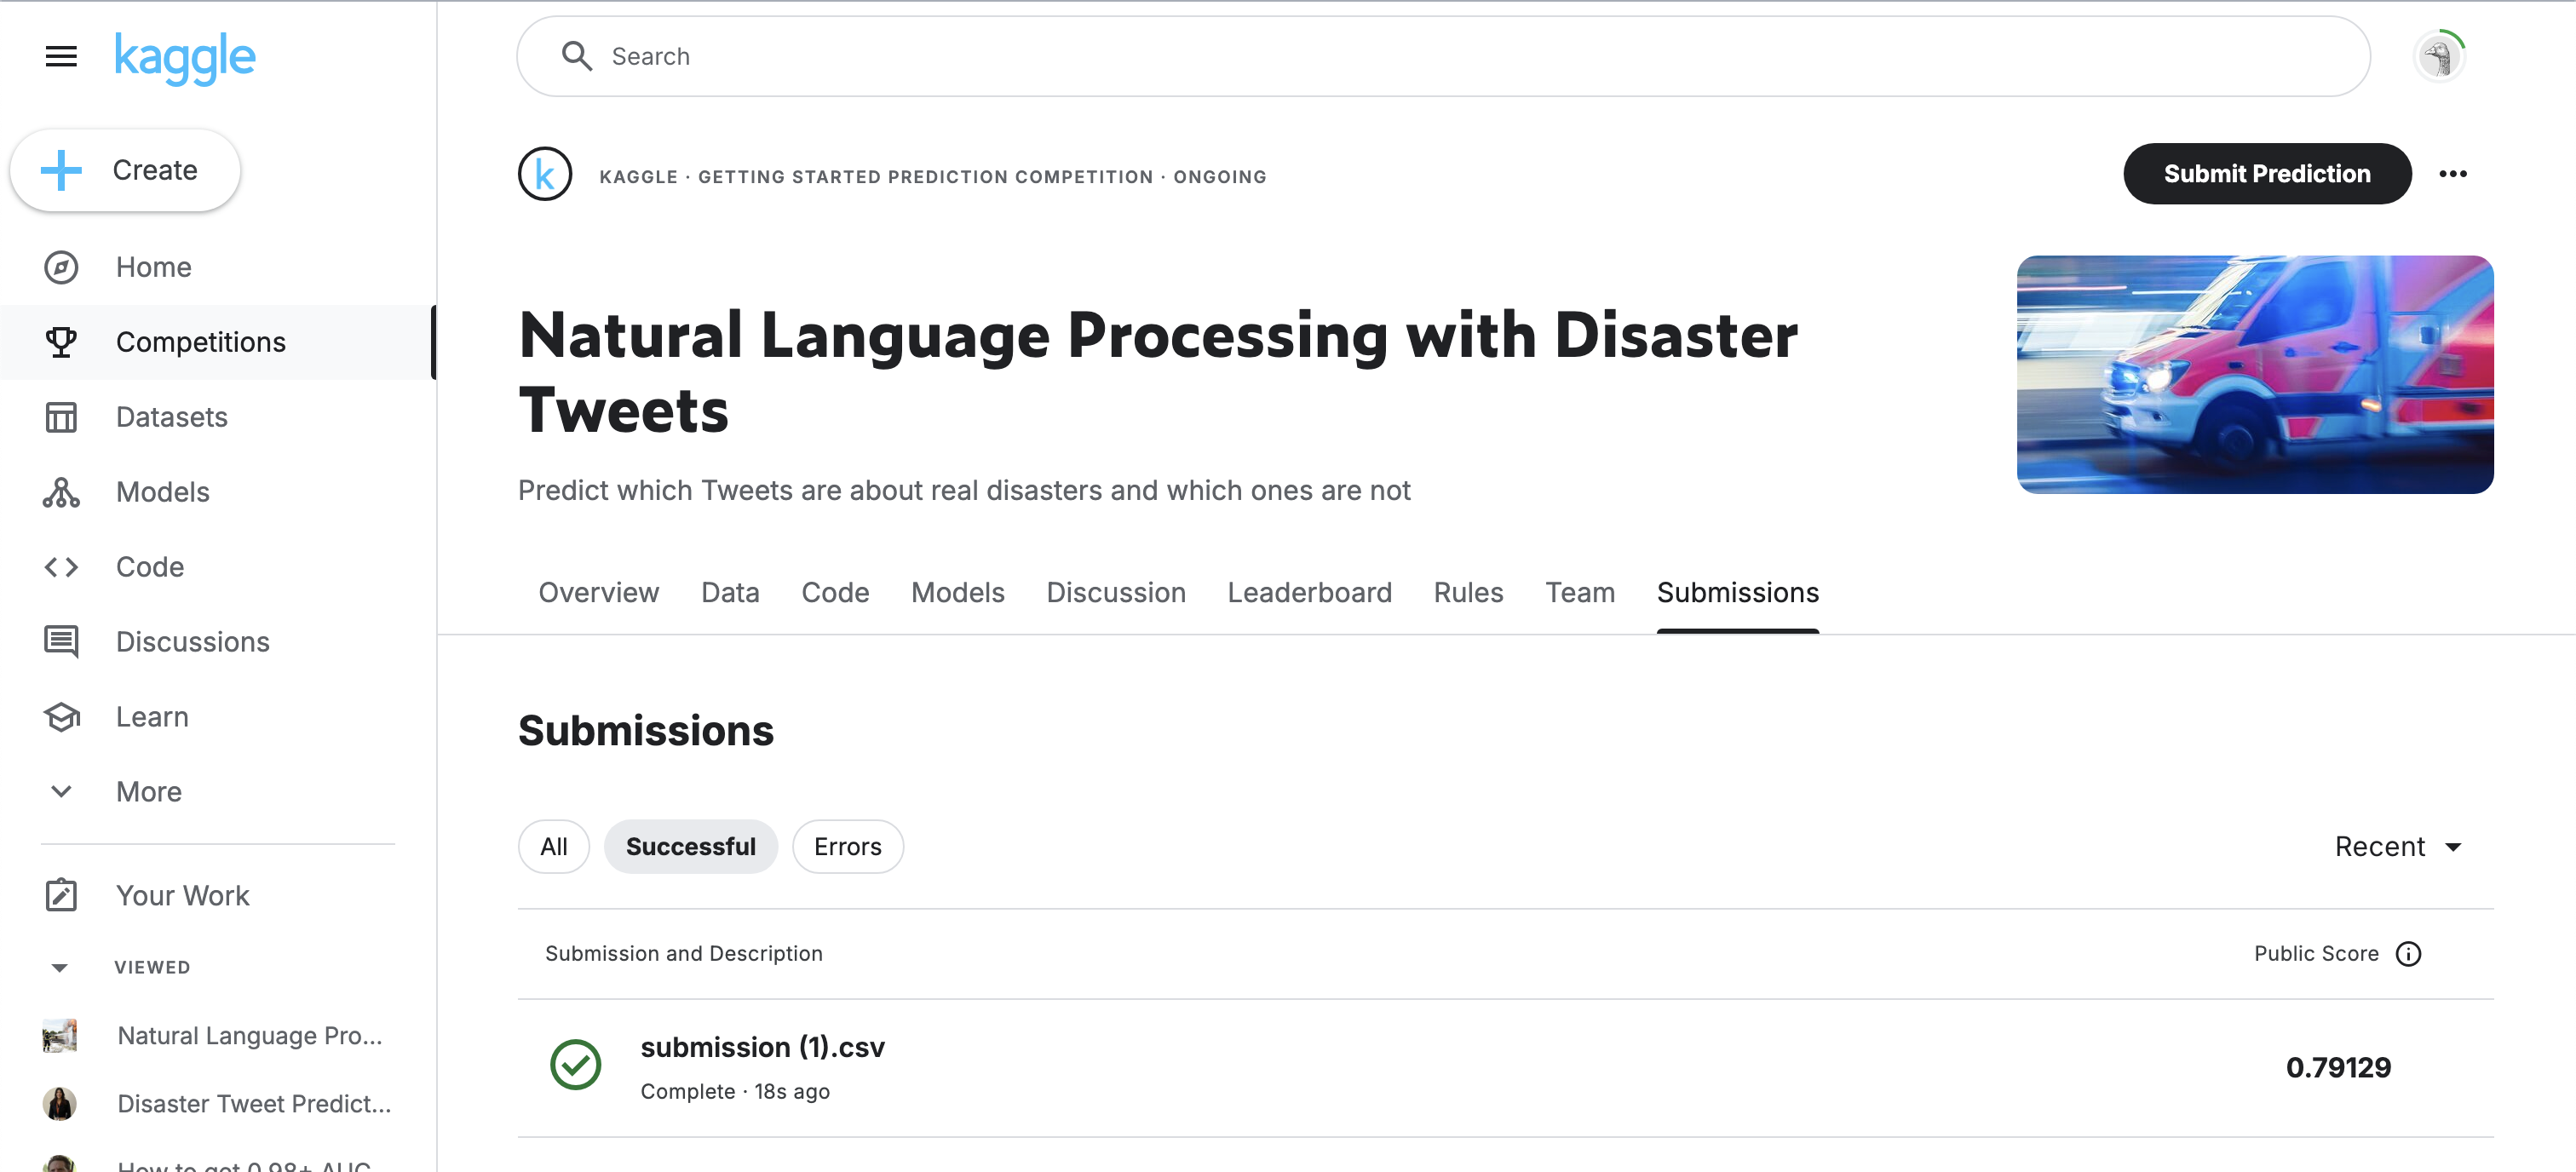

~End